Мы будем анализировать результаты автомобильных гонок.

Для начала подключим Google Colab к
Google Drive, чтобы считать данные из файла. А затем подключим необходимые библиотеки для анализа и визуализации данных.

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

Считаем данные из таблицы с информацией о гонках, проведённых в период с 2001 по 2025 год.

In [57]:
df = pd.read_csv("/content/drive/MyDrive/Python/Formula2_Race_Results.csv")
df = df[df["Date"] < "2025"]

Визуализируем данные.

На первой диаграмме представлена зависимость количества кругов от позиции команды. Можно видеть, что большинству участников удалось совершить 20 кругов и в целом результаты разнятся мало.

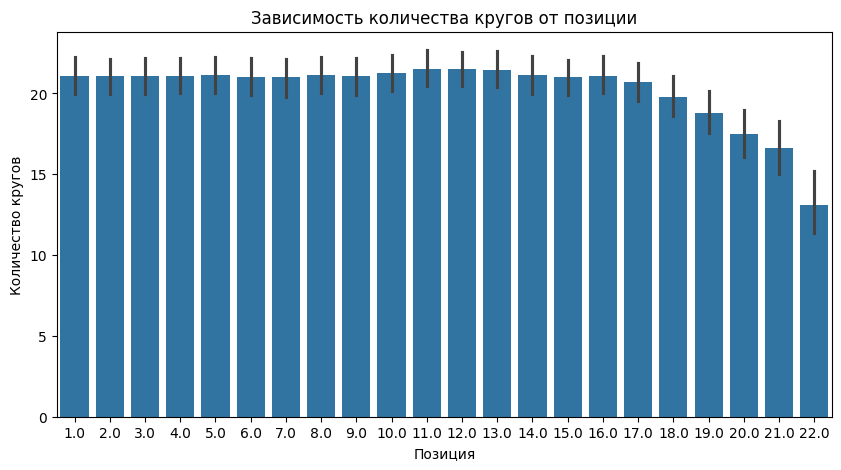

In [58]:

plt.figure(figsize = (10, 5))
sns.barplot(x = 'Position', y = 'Laps', data = df)
plt.title('Зависимость количества кругов от позиции')
plt.xlabel('Позиция')
plt.ylabel('Количество кругов')
plt.show()

На следующем графике изображена средняя скорость команды по трассам, пройденным за весь период с 2001 по 2025 год. Можно видеть, что она приблизительно одинакова для всех команд и колеблется около отметки в 150-175 км/час.

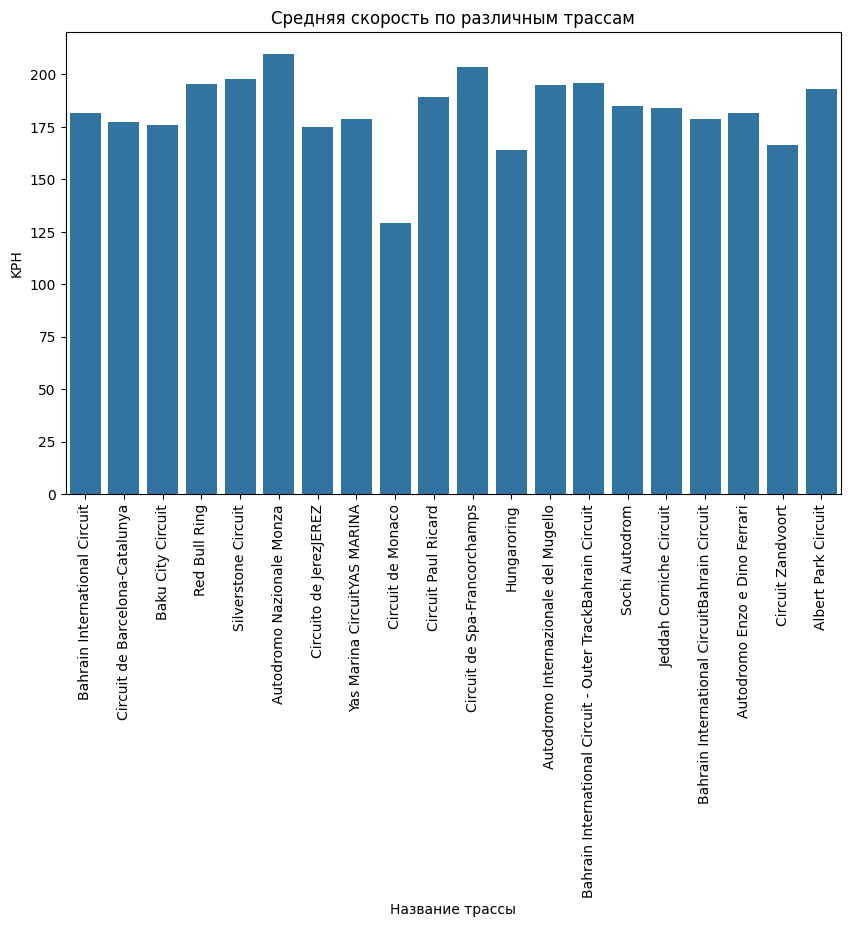

In [59]:
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Track Name', y = 'KPH', data = df, errorbar = None)
plt.xticks(rotation = 90)
plt.title('Средняя скорость по различным трассам')
plt.xlabel('Название трассы')
plt.ylabel('KPH')
plt.show()

Следующая диаграмма иллюстрирует зависимость результата команды, первой завершившей прохождение трассы, от длины трассы.

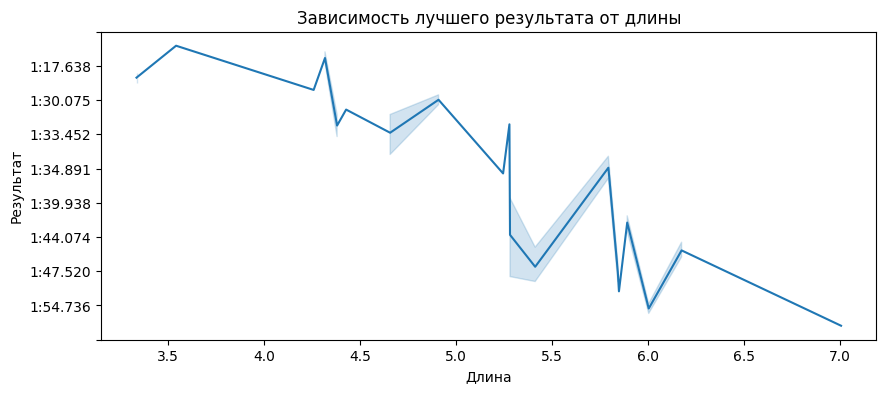

In [60]:
new = df[df["Position"] == 1.0]
new = new.sort_values(by = "Best Lap Time")
new = new[new['Race Type'] == 'Sprint Race Results']
plt.figure(figsize = (10, 4))
sns.lineplot(x = "Length (Km)", y = "Best Lap Time", data = new)
plt.title("Зависимость лучшего результата от длины")
plt.xlabel("Длина")
plt.ylabel("Результат")
n = 10 # Просто напишите, сколько нужно значений по оси Y

y_min, y_max = plt.gca().get_ylim()  # Получаем текущие границы оси Y
yticks = np.linspace(y_min, y_max, n)  # Создаем n значений
plt.gca().set_yticks(yticks)  # Устанавливаем деления
plt.show()

Следующая круговая диаграмма содержит информацию только про пять команд. Эта диаграмма показывает, какая доля участников из этих команд была в пятерке лучших на соревновании. Очевидным образом, лидирует команда Art Grand Prix.

Text(0.5, 1.0, 'Соотношения количества участников, попавших в топ 5, среди первых 5 команд в алфавитном порядке')

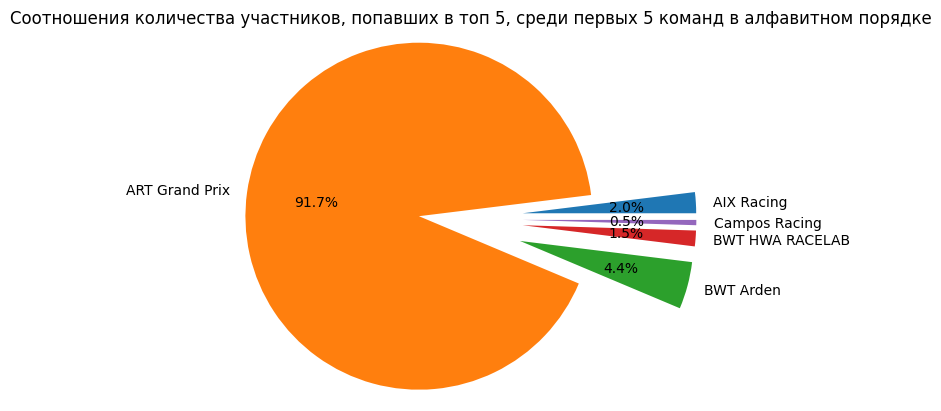

In [61]:
best_comands = df[df["Position"] <= 5.0]
best_comands = best_comands.sort_values(by = "Team Name")
con = [0]
count = 0
answer = {}
for i in best_comands['Team Name']:
  if con[0] != i:
    con[0] = i
    count += 1
    answer[i] = 1
    if count == 5:
      break
  else:
    answer[i] += 1
values = list(answer.values())
labels = list(answer.keys())
explode = (0.5, 0.1, 0.5, 0.5, 0.5)
fig, ax = plt.subplots()
ax.pie(values, labels = labels, autopct='%1.1f%%', shadow = False, explode = explode)
ax.axis("equal")
plt.title("Соотношения количества участников, попавших в топ 5, среди первых 5 команд в алфавитном порядке")


### Теперь гипотезы


Гипотеза 1. Длина трассы положительно коррелирует с временем гонки.


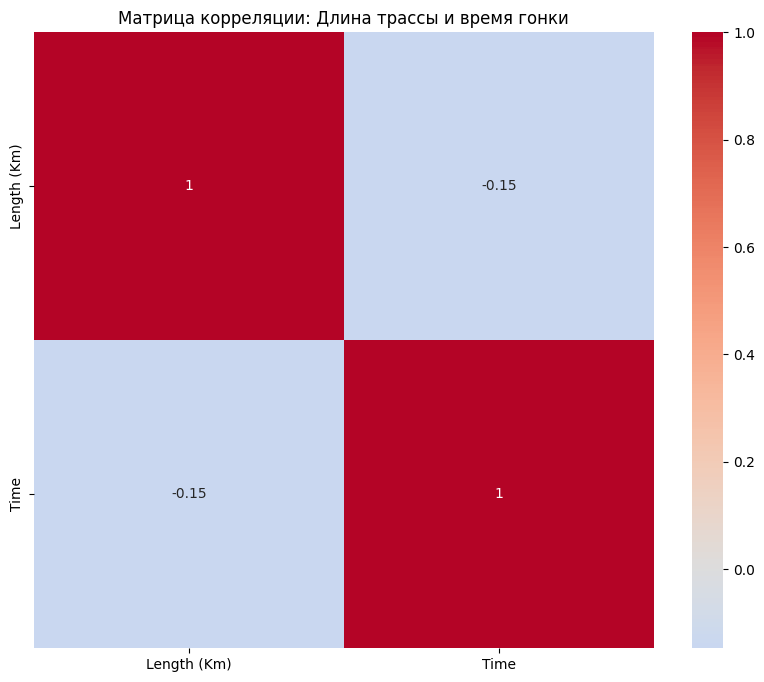

In [62]:
df_race = df[df['Race Type'].str.contains('Race Results')]

df_race.loc[:, 'Time'] = pd.to_timedelta(df_race['Time'], errors = 'coerce').dt.total_seconds()

correlation_matrix_2 = df_race[['Length (Km)', 'Time']].dropna().corr()

plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix_2, annot = True, cmap = 'coolwarm', center = 0)
plt.title('Матрица корреляции: Длина трассы и время гонки')
plt.show()

Вывод: матрица корреляции показывает, что есть слабая отрицательная корреляция, и гипотеза не верна.

Гипотеза 2. Ниже график показывает, как связано время лучшего круга на тренировке и на соревновании. Гипотеза состоит в том, что, чем лучше время, показанное во время тренировки, тем лучше время, показанное во время спринтерской гонки.

<Figure size 2000x1000 with 0 Axes>

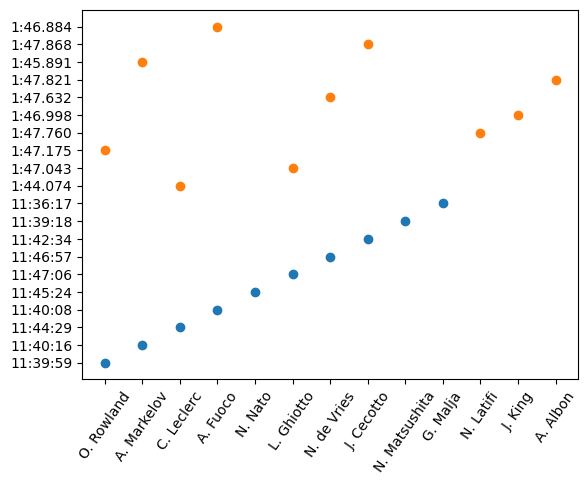

In [63]:
# лучшее время круга во время тренировки и во время спринтерской гонки
best_resolt_practice = df[df['Race Type'] == "Free Practice Results"].head(10)
best_resolt_sprint = df[df['Race Type'] == "Sprint Race Results"].head(10)

practice_Dr = best_resolt_practice["Driver Name"].tolist()
practice_Best = best_resolt_practice["Best Lap Time"].tolist()

sprint_Dr = best_resolt_sprint["Driver Name"].tolist()
sprint_Best = best_resolt_sprint["Best Lap Time"].tolist()

plt.figure(figsize=(20, 10))


fig, axes = plt.subplots()
plt.scatter(practice_Dr, practice_Best)
plt.scatter(sprint_Dr, sprint_Best)

plt.xticks(rotation=55)
plt.show()

По графику видно, что никакой явной корреляции между двумя показателями нет. Поэтому гипотеза не подтверждается.

Гипотеза 3. Чем меньше лучшее время круга, тем выше средняя скорость на гонках.

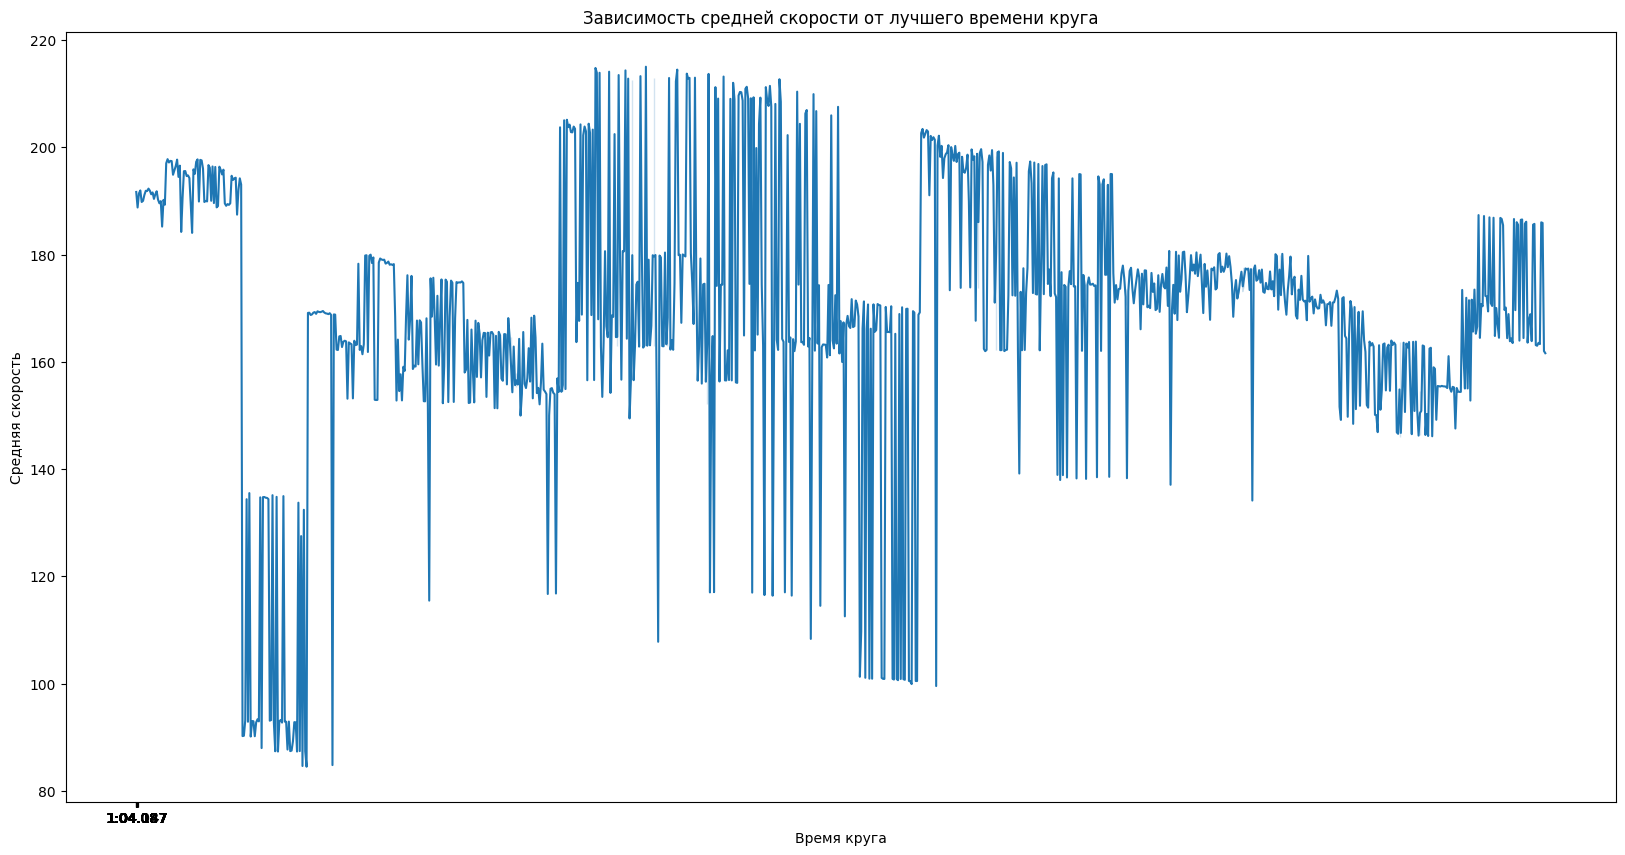

In [64]:
# чем меньше бест время, тем выше средняя скорость на футуре гонках
# resolt_feature = df[df['Race Type'] == "Feature Race Results"].head(10)
resolt_feature = df[df['Race Type'] == "Feature Race Results"]
resolt_feature = resolt_feature.sort_values(by = "Best Lap Time")
plt.figure(figsize = (20, 10))

n = 20

x_min, x_max = plt.gca().get_xlim()
xticks = np.linspace(x_min, x_max, n)
plt.gca().set_xticks(xticks)

sns.lineplot(x = "Best Lap Time", y = "KPH", data = resolt_feature)
plt.title("Зависимость средней скорости от лучшего времени круга")
plt.xlabel("Время круга")
plt.ylabel("Средняя скорость")
plt.show()

По графику видно, что с увеличением времени круга средняя скорость падает. Гипотеза подтверждена.


# Машинное обучение

Попробуем предсказывать позицию гонщика в гонке.



Исходя из наших данных мы можем создать новые признаки, которые могут быть полезными для дальнейшего анализа:
1.   Средняя скорость заезда всех гонщиков
2.   Среднее время кругавсех гонщиков



In [65]:
# конвертация времени
def convert_lap_time(time_str):
    if pd.isna(time_str):
        return None
    try:
        minutes, seconds = time_str.split(':')
        return int(minutes) * 60 + float(seconds)
    except:
        return None

In [66]:
average_speed = df.groupby(['URL', 'Race Type'])['KPH'].mean().reset_index()
average_speed.columns = ['URL', 'Race Type', 'Average Speed (KPH)']

df = df.merge(average_speed, on = ['URL', 'Race Type'])

In [67]:
df['Best Lap Time (s)'] = df['Best Lap Time'].apply(convert_lap_time)
average_lap_time = df.groupby(['URL', 'Race Type'])['Best Lap Time (s)'].mean().reset_index()
average_lap_time.columns = ['URL', 'Race Type', 'Average Lap Time (s)']

df = df.merge(average_lap_time, on = ['URL', 'Race Type'])

In [68]:
df.dropna(subset = ['Position'], inplace = True)

In [69]:
features = ['Laps', 'Best Lap Time (s)', 'Length (Km)']
X = df[features]
y = df['Position']

In [70]:
imputer = SimpleImputer(strategy = 'mean')
X = imputer.fit_transform(X)

random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = random_state)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state = random_state),
    "Gradient Boosting": GradientBoostingRegressor(random_state = random_state),
    "XGBoost": XGBRegressor(random_state = random_state)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    results[model_name] = mae
    print(f'{model_name} Mean Absolute Error: {mae}')

results_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['Mean Absolute Error'])

Linear Regression Mean Absolute Error: 4.908280176260638
Decision Tree Mean Absolute Error: 4.932840195208732
Gradient Boosting Mean Absolute Error: 4.756288392105981
XGBoost Mean Absolute Error: 4.802654236994291


**Вывод**:
модели получились примерно одинаковыми. Попробуем улучшить XGBoost с помощбю подбора параметров.

In [71]:
param_dist = {
    'n_estimators': range(50, 1000, 50),
    'learning_rate': np.linspace(0.01, 0.2, 20),
    'max_depth': range(3, 15, 2),
    'subsample': np.linspace(0.7, 1.0, 10),
    'colsample_bytree': np.linspace(0.7, 1.0, 10),
    'gamma': np.linspace(0, 0.5, 10)
}

xgb_model = XGBRegressor(random_state = random_state)
random_search = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_dist,
                                   n_iter = 200, cv = 3, scoring = 'neg_mean_absolute_error',
                                   n_jobs = -1, verbose = 0, random_state = random_state,
                                   error_score = 'raise')

try:
    random_search.fit(X_train, y_train)
except ValueError as e:
    print(f"Произошла ошибка: {e}")

if random_search.best_estimator_ is not None:
    best_xgb_model = random_search.best_estimator_

    y_pred = best_xgb_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Best XGBoost Model Mean Absolute Error: {mae}')
    print(f'Best Parameters:')
    for param, value in random_search.best_params_.items():
        print(f'{param}: {value}')

    best_results_df = pd.DataFrame([{'Model': 'XGBoost', 'Mean Absolute Error': mae,
                                     'Best Parameters': random_search.best_params_}])
else:
    print("RandomizedSearchCV не нашел ни одной подходящей комбинации гиперпараметров.")

Best XGBoost Model Mean Absolute Error: 4.787651647768523
Best Parameters:
subsample: 1.0
n_estimators: 950
max_depth: 9
learning_rate: 0.09
gamma: 0.2777777777777778
colsample_bytree: 0.7666666666666666


**Вывод**:
мы смогли улучшить нашу модель, но очень незначительно, скорее всего это из-за того, что данных недостаточно для обучения модели. Возможно, добавление новых признаков поможет улучшить модель, но к сожалению, у нас нет данных для этого, так как мы не можем использовать данные из будущего